# Import modules and load data

In [1]:
import mysql.connector
import pandas as pd
import numpy as np
import pickle 

import seaborn as sns
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn import model_selection
import xgboost as xgb
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, precision_score, recall_score
from sklearn.model_selection import RandomizedSearchCV
from collections import Counter
import pickle
import operator
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import make_scorer
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
import time
acc = make_scorer(accuracy_score)


from sklearn.multiclass import OneVsRestClassifier

In [2]:
import random

def sampleData(DataFrame, ratio):
    df_size = len(DataFrame.index)
    sample_size = int(round(ratio * df_size))
    if sample_size == df_size:
        sample_size = sample_size - 1
        indexes = random.sample(range(df_size), sample_size)
        sample = DataFrame.iloc[indexes, : ]
        return sample

    elif sample_size == 0:
        sample_size = 1
        indexes = random.sample(range(df_size), sample_size)
        sample = DataFrame.iloc[indexes, : ]
        return sample

    else:
        indexes = random.sample(range(df_size), sample_size)
        sample = DataFrame.iloc[indexes, : ]
        return sample

In [5]:
#import data
atlas = pd.read_csv('filtered_90_tissue_predictor_healthy_atlas_shotgun_nofluid.csv', sep=",")
atlas.head()

,A0A075B6H7,A0A075B6H8,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6K4,A0A075B6Q5,A0A087WSY6,A0A0A0MRZ7,A0A0A0MS14,...,Q9Y6U3,Q9Y6V0,Q9Y6W3,Q9Y6W5,Q9Y6X5,Q9Y6X8,Q9Y6X9,Q9Y6Y0,Q9Y6Y8,tissue_name
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Brain
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Brain
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Brain
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Brain
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Brain


The original atlas was filtered on all proteins being present in 90 of a tissue (significant presence). All are healthy samples.

Check the class balance

In [4]:
atlas.shape

(1338, 4982)

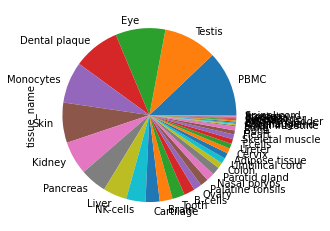

In [5]:
atlas['tissue_name'].value_counts().plot.pie()

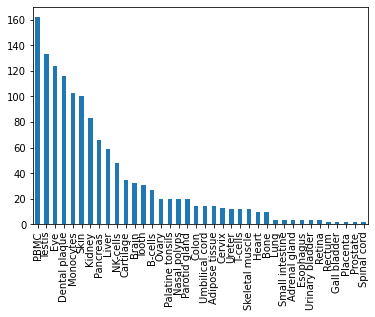

In [6]:
atlas['tissue_name'].value_counts().plot(kind='bar')

We will balance the atlas a little bit. <br>
1. Reduce the number of blood samples by random undersampling untill the same amount of samples as the second highest class are left. (from 1059 to 194)
2. Drop the tissues that are too low. 
Uterus                          2
Anus                            2
Seminal vesicle                 2
Breast                          2
Epidymis                        2
Paratyroid gland                2
Trachea                         2
Smooth muscle                   1

In [7]:
pd.set_option('display.max_rows', None)  
tissue_counts = atlas['tissue_name'].value_counts().to_frame()
print(tissue_counts)

                  tissue_name
PBMC                      162
Testis                    133
Eye                       124
Dental plaque             116
Monocytes                 103
Skin                      100
Kidney                     83
Pancreas                   66
Liver                      59
NK-cells                   48
Cartilage                  35
Brain                      32
Tooth                      31
B-cells                    27
Ovary                      20
Palatine tonsils           20
Nasal polyps               20
Parotid gland              20
Colon                      14
Umbilical cord             14
Adipose tissue             14
Cervix                     13
Ureter                     12
T-cells                    12
Skeletal muscle            12
Heart                      10
Bone                       10
Lung                        3
Small intestine             3
Adrenal gland               3
Esophagus                   3
Urinary bladder             3
Retina    

# Drop low tissues

In [8]:
low_tissues = tissue_counts.index[tissue_counts['tissue_name']<3].tolist()
atlas = atlas[~atlas['tissue_name'].isin(low_tissues)]

In [9]:
tf = dict(Counter(atlas['tissue_name']))
tf = sorted(tf.items(), key=operator.itemgetter(1), reverse=True)
tf = dict(tf)

In [10]:
tf

{'PBMC': 162,
 'Testis': 133,
 'Eye': 124,
 'Dental plaque': 116,
 'Monocytes': 103,
 'Skin': 100,
 'Kidney': 83,
 'Pancreas': 66,
 'Liver': 59,
 'NK-cells': 48,
 'Cartilage': 35,
 'Brain': 32,
 'Tooth': 31,
 'B-cells': 27,
 'Ovary': 20,
 'Nasal polyps': 20,
 'Palatine tonsils': 20,
 'Parotid gland': 20,
 'Colon': 14,
 'Adipose tissue': 14,
 'Umbilical cord': 14,
 'Cervix': 13,
 'T-cells': 12,
 'Ureter': 12,
 'Skeletal muscle': 12,
 'Heart': 10,
 'Bone': 10,
 'Adrenal gland': 3,
 'Esophagus': 3,
 'Small intestine': 3,
 'Lung': 3,
 'Retina': 3,
 'Urinary bladder': 3}

In [11]:
atlas_c = atlas.copy(deep=True)
y = atlas_c.pop('tissue_name').to_numpy()
X = atlas_c

# Using class weight in the predictors <br>
To further balance the algorithm, the class will be assigned a specific weight based on the number of samples in this class. 

The weight of a class is determined by dividing negative samples/ positive samples. So if a class contains 15 samples in a dataset of 100 samples, the class weight will be 85/15=5,667

In [12]:
atlas.head()

,A0A075B6H7,A0A075B6H8,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6K4,A0A075B6Q5,A0A087WSY6,A0A0A0MRZ7,A0A0A0MS14,...,Q9Y6U3,Q9Y6V0,Q9Y6W3,Q9Y6W5,Q9Y6X5,Q9Y6X8,Q9Y6X9,Q9Y6Y0,Q9Y6Y8,tissue_name
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Brain
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Brain
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Brain
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Brain
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Brain


In [13]:
atlas.shape

(1328, 4982)

In [14]:
som = atlas.shape[0]
weight_and_label = pd.DataFrame(columns=['label', 'weight'])
i = 0
for key, value in tf.items():
    i += 1
    w = (som - value)/value
    weight_and_label.loc[i] = [key, w]

In [15]:
train_df = pd.DataFrame()
test_df = pd.DataFrame()
validation_df = pd.DataFrame()

tissues = atlas['tissue_name'].unique()
DataFrameDict = {elem : pd.DataFrame for elem in tissues}
for key in DataFrameDict.keys():
    DataFrameDict[key] = atlas[:][atlas['tissue_name'] == key]

for key in DataFrameDict.keys():
    train = sampleData(DataFrameDict[key], 0.80)
    train_df = train_df.append(train)

    test = DataFrameDict[key].drop(train.index)
    test_df = test_df.append(test)

y_train = train_df.pop('tissue_name').values
X_train = train_df.values
y_test = test_df.pop('tissue_name').values
X_test = test_df.values

X_train = pd.DataFrame(X_train, columns=(atlas.columns)[:-1])
X_test = pd.DataFrame(X_test, columns=(atlas.columns)[:-1])

In [16]:
train_label_weight = pd.merge(pd.DataFrame(y_train, columns=['label']), weight_and_label, how='left', on='label')
label_weight = pd.merge(pd.DataFrame(y, columns=['label']), weight_and_label, how='left', on='label')

The weights are linked to the targets in the training data and in the complete dataset.

In [17]:
train_weights = train_label_weight['weight'].to_numpy()
train_weights = train_weights.flatten()
train_weights

weights = label_weight['weight'].to_numpy()
weights = weights.flatten()
weights

array([40.5       , 40.5       , 40.5       , ...,  9.70967742,
        9.70967742,  9.70967742])

In [18]:
dict_train_label_weight = train_label_weight.drop_duplicates()
dict_train_label_weights = dict(zip(train_label_weight.label, train_label_weight.weight))

# Comparing predictive algortihms performance on the training data <br>
Using the cross val scores, several metrics of several algorithms are gathered to compare performance and choose 1 algorithm for further tuning.

Each model had the necessary parameters to handle multilabel classification eg. the multisoftprob objective in XGBoost

In [19]:
# Define a function that compares the CV perfromance of a set of predetrmined models 
#https://towardsdatascience.com/cross-validation-and-hyperparameter-tuning-how-to-optimise-your-machine-learning-model-13f005af9d7d
def cv_comparison(models, X, y, cv):
    # Initiate a DataFrame for the averages and a list for all measures
    cv_scores = pd.DataFrame()
    accs = []
    f1s = []
    precs = []
    recs = []
    f1s_w = []
    precs_w = []
    recs_w = []

    # Loop through the models, run a CV, add the average scores to the DataFrame and the scores of 
    # all CVs to the list
    for model, name in zip(models, names):
        print(name)
        start = time.time()
        acc = np.round(cross_val_score(model, X, y, scoring='accuracy', cv=cv), 4)
        accs.append(acc)
        acc_avg = round(np.mean(acc[~np.isnan(acc)]), 4)
        f1 = np.round(cross_val_score(model, X, y, scoring='f1_macro', cv=cv), 4)
        f1s.append(f1)
        f1_avg = round(np.mean(f1[~np.isnan(f1)]), 4)
        prec = np.round(cross_val_score(model, X, y, scoring='precision_macro', cv=cv), 4)
        precs.append(prec)        
        prec_avg = round(np.mean(prec[~np.isnan(prec)]), 4)
        rec = np.round(cross_val_score(model, X, y, scoring='recall_macro', cv=cv), 4)
        recs.append(rec)        
        rec_avg = round(np.mean(rec[~np.isnan(rec)]), 4)

        f1_w = np.round(cross_val_score(model, X, y, scoring='f1_weighted', cv=cv), 4)
        f1s_w.append(f1_w)
        f1_w_avg = round(np.mean(f1_w[~np.isnan(f1_w)]), 4)
        prec_w = np.round(cross_val_score(model, X, y, scoring='precision_weighted', cv=cv), 4)
        precs_w.append(prec_w)        
        prec_w_avg = round(np.mean(prec_w[~np.isnan(prec_w)]), 4)
        rec_w = np.round(cross_val_score(model, X, y, scoring='recall_weighted', cv=cv), 4)
        recs_w.append(rec_w)        
        rec_w_avg = round(np.mean(rec_w[~np.isnan(rec_w)]), 4)
        cv_scores[str(name)] = [acc_avg, f1_avg, prec_avg, rec_avg, f1_w_avg, prec_w_avg, rec_w_avg]
        print(time.time() - start)
    cv_scores.index = ['Accuracy', 'f1_macro', 'precision_macro', 'recall_macro', 'f1_weighted', 'precision_weighted', 'recall_weighted']
    return cv_scores,accs, f1s, precs, recs, f1s_w, precs_w, recs_w

In [20]:
num_classes =len(np.unique(y))
print(num_classes)

33


In [ ]:
from sklearn.model_selection import RepeatedStratifiedKFold

log_unbal = LogisticRegression(random_state=42, multi_class='multinomial', n_jobs=-1)
log=LogisticRegression(random_state=42, multi_class='multinomial', class_weight=dict_train_label_weights, n_jobs=-1)
log_bal=LogisticRegression(random_state=42, multi_class='multinomial', class_weight='balanced', n_jobs=-1)

rf_unbal = RandomForestClassifier(random_state=42, n_jobs=-1)
rf=RandomForestClassifier(random_state=42, class_weight=dict_train_label_weights, n_jobs=-1)
rf_bal=RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1)
rf_sub=RandomForestClassifier(random_state=42, class_weight='balanced_subsample', n_jobs=-1)

brf_unbal = BalancedRandomForestClassifier(random_state=42, n_jobs=-1)
brf = BalancedRandomForestClassifier(random_state=42, class_weight=dict_train_label_weights, n_jobs=-1)
brf_bal = BalancedRandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1)
brf_sub = BalancedRandomForestClassifier(random_state=42, class_weight='balanced_subsample', n_jobs=-1)

xgb_unbal = XGBClassifier(random_state=42,objective='multi:softprob', eval_metric='mlogloss', num_class=num_classes, n_jobs=-1)
xgb=XGBClassifier(random_state=42, objective='multi:softprob', eval_metric='mlogloss', num_class=num_classes, weight=train_weights, n_jobs=-1)

svm_unbal=SVC(random_state=42)
svm=SVC(random_state=42, class_weight=dict_train_label_weights)

models = [log_unbal, log, log_bal, rf_unbal, rf, rf_bal, rf_sub, brf_unbal, brf, brf_bal, brf_sub, xgb_unbal, xgb, svm_unbal, svm]
names = ['LogisticRegression unbalanced', 'LogisticRegression dict balanced', 'LogisticRegression balanced', 'RandomForest unbalanced', 'RandomForest dict balanced', 'RandomForest balanced', 'Random Forest balanced subsample', 'Balanced RandomForest',
'Balanced RandomForest balanced','Balanced RandomForest balanced subsample', 'XGBClassifier unbalanced', 'XGBClassifier dict balanced', 'SVM unbalanced', 'SVM']

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=42)
comp, accs, f1s, precs, recs, f1s_w, precs_w, recs_w = cv_comparison(models, X_train, y_train, cv=cv)

LogisticRegression unbalanced


/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n

1861.320637702942
LogisticRegression dict balanced


/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
joblib.externals.loky.process_executor._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py", line 431, in _process_worker
    r = call_item()
  File "/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py", line 285, in __call__
    return self.fn(*self.args, **self.kwargs)
  File "/home/compomics/min

1156.4551632404327
LogisticRegression balanced


/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
joblib.externals.loky.process_executor._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py", line 431, in _process_worker
    r = call_item()
  File "/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py", line 285, in __call__
    return self.fn(*self.args, **self.kwargs)
  File "/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/joblib/_parallel_backends.py", line 595, in __call__
    return self.func(*args, **kwargs)
  File "/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/joblib/parallel.py", line 

1036.796838760376
RandomForest unbalanced


/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n

136.48492908477783
RandomForest dict balanced


/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/sklearn/ensemble/_forest.py", line 331, in fit
    y, expanded_class_weight = self._validate_y_class_weight(y)
  File "/home/compomics/miniconda3/envs/tissuespecific/lib/pytho

43.5557918548584
RandomForest balanced


/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n

142.7561285495758
Random Forest balanced subsample


/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n

143.61747312545776
Balanced RandomForest


/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n

157.34479141235352
Balanced RandomForest balanced


/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/imblearn/ensemble/_forest.py", line 451, in fit
    y_encoded, expanded_class_weight = self._validate_y_class_weight(y)
  File "/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/sklearn/ensemble/_forest.py", line 605, in _validate_y_class_weight
    y_original)
  File "/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return 

46.926114320755005
Balanced RandomForest balanced subsample


/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n

158.53748607635498
XGBClassifier unbalanced


/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n

158.20172333717346
XGBClassifier dict balanced


/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/compomics/miniconda3/e

23789.68152332306
SVM unbalanced


/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:52:16] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:54:35] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:56:52] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:59:04] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:01:19] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:03:34] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:05:52] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:08:08] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:10:19] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:12:34] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:14:50] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:17:10] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:19:25] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:21:39] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:23:54] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:26:10] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:28:30] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:30:44] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:32:56] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:35:12] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:37:29] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:39:49] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:42:05] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:44:20] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:46:36] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:48:51] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:51:11] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:53:28] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:55:40] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:57:56] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:00:11] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:02:29] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:04:45] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:06:57] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:09:12] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:11:28] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:13:48] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:16:03] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:18:16] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:20:31] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:22:48] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:25:08] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:27:22] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:29:34] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:31:50] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:34:07] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:36:26] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:38:43] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:40:57] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:43:12] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:45:27] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:47:47] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:50:05] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:52:16] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:54:32] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [

[10:56:48] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:59:06] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:01:22] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:03:34] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:05:48] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [

[11:08:04] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:10:24] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:12:40] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:14:53] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:17:08] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [

[11:19:24] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:21:44] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:23:59] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:26:10] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:28:26] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [

[11:30:44] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:33:04] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:35:20] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:37:34] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:39:50] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [

[11:42:05] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:44:25] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:46:43] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:48:55] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:51:11] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:53:26] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:55:44] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:58:01] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:00:14] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:02:28] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:04:44] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:07:04] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:09:19] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:11:32] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:13:47] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_clas

[12:16:03] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:18:24] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:20:38] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:22:49] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:25:05] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:27:23] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:29:42] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:31:59] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:34:13] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:36:29] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:38:44] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:41:04] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:43:22] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:45:34] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:47:50] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:50:05] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:52:23] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:54:40] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:56:53] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:59:08] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:01:24] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:03:43] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:05:59] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:08:12] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:10:28] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:12:44] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:15:04] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:17:18] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:19:30] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:21:45] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:24:03] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:26:23] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:28:39] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:30:53] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:33:09] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:35:24] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:37:44] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:40:02] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:42:13] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:44:29] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [

[13:46:44] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:49:03] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:51:19] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:53:31] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:55:46] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [

[13:58:01] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:00:21] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:02:37] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:04:50] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:07:06] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [

[14:09:21] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:11:41] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:13:55] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:16:06] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:18:22] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [

[14:20:39] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:22:58] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:25:15] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:27:29] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:29:44] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [

[14:31:59] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:34:19] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:36:36] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:38:48] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:41:03] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:43:18] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:45:36] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:47:52] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:50:04] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:52:18] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:54:34] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:56:53] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:59:09] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:01:22] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:03:37] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_clas

[15:05:52] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:08:12] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:10:27] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:12:38] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:14:52] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:17:10] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:19:29] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:21:46] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:24:00] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:26:15] WARNING: ../src/learner.cc:573: 
Parameters: { "weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


23775.046488285065
SVM


/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n

895.4014496803284


In [ ]:
comp

,LogisticRegression unbalanced,LogisticRegression dict balanced,LogisticRegression balanced,RandomForest unbalanced,RandomForest dict balanced,RandomForest balanced,Random Forest balanced subsample,Balanced RandomForest,Balanced RandomForest balanced,Balanced RandomForest balanced subsample,XGBClassifier unbalanced,XGBClassifier dict balanced,SVM unbalanced,SVM
Accuracy,0.4859,0.8398,0.6333,0.9641,0.9761,0.9706,0.9705,0.6903,0.6416,0.6179,0.6949,0.9579,0.9579,0.8623
f1_macro,0.1934,0.7261,0.5234,0.8684,0.9265,0.8977,0.9012,0.6383,0.6203,0.5866,0.6522,0.8358,0.8358,0.6240
precision_macro,0.2114,0.7525,0.5918,0.8755,0.9419,0.9042,0.9094,0.6787,0.6890,0.6424,0.6971,0.8480,0.8480,0.6541
recall_macro,0.2126,0.7247,0.5354,0.8723,0.9233,0.8983,0.9007,0.6962,0.6613,0.6490,0.6980,0.8372,0.8372,0.6276
f1_weighted,0.4077,0.8633,0.6477,0.9570,0.9722,0.9660,0.9666,0.7134,0.6619,0.6219,0.7182,0.9504,0.9504,0.8320
precision_weighted,0.4289,0.9116,0.7892,0.9549,0.9733,0.9648,0.9666,0.8606,0.8706,0.8252,0.8615,0.9486,0.9486,0.8258
recall_weighted,0.4859,0.8398,0.6333,0.9641,0.9761,0.9706,0.9705,0.6903,0.6416,0.6179,0.6949,0.9579,0.9579,0.8623


In [ ]:
comp.to_csv('comparison_predictors_balancing.csv', sep='/')

# RandomForest

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    y_test_trans = list(le.inverse_transform(list(y_test))) 
    tick_marks = np.arange(len(np.unique(y_test_trans)))
    plt.xticks(tick_marks, np.unique(y_test_trans), rotation=90)
    plt.yticks(tick_marks, np.unique(y_test_trans))
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

In [129]:
result_df = pd.DataFrame(columns=['model','Accuracy', 'f1_macro', 'precision_macro', 'recall_macro', 'f1_weighted', 'precision_weighted', 'recall_weighted'])
result_df_cv = pd.DataFrame(columns=['model','fold', 'Accuracy', 'f1_macro', 'precision_macro', 'recall_macro', 'f1_weighted', 'precision_weighted', 'recall_weighted'])

In [130]:
forest= RandomForestClassifier(n_jobs=-1, class_weight='balanced_subsample')
forest.fit(X_train, y_train)
baseline_predictions =  forest.predict(X_test)
fm = f1_score(y_test, baseline_predictions, average="macro")
fw = f1_score(y_test, baseline_predictions, average="weighted")
acc = accuracy_score(y_test, baseline_predictions)
pw = precision_score(y_test, baseline_predictions, average='weighted')
pm = precision_score(y_test, baseline_predictions, average='macro')
rw = recall_score(y_test, baseline_predictions, average='weighted')
rm = recall_score(y_test, baseline_predictions, average='macro')
df_length = len(result_df)
result_df.loc[df_length] = ['RandomForest_baseline', acc, fm, pm, rm, fw, pm, rw]

In [35]:
result_df

,model,Accuracy,f1_macro,precision_macro,recall_macro,f1_weighted,precision_weighted,recall_weighted
0,RandomForest_baseline,0.977612,0.95014,0.958065,0.94859,0.975654,0.958065,0.977612


In [37]:
fold_number = 0
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
for train_index, test_index in skf.split(X, y):
    fold_number += 1
    train = atlas.iloc[train_index,:]
    X_train_cv = train.iloc[:,:-1]
    y_train_cv = train.iloc[:,-1]
    test = atlas.iloc[test_index,:]
    X_test_cv = test.iloc[:, :-1]
    y_test_cv = test.iloc[:,-1]
    forest = RandomForestClassifier(random_state=42, class_weight='balanced_subsample')
    forest.fit(X_train_cv, y_train_cv)
    importances = forest.feature_importances_
    baseline_predictions =  forest.predict(X_test_cv)
    fm = f1_score(y_test_cv, baseline_predictions, average="macro")
    fw = f1_score(y_test_cv, baseline_predictions, average="weighted")
    acc = accuracy_score(y_test_cv, baseline_predictions)
    pw = precision_score(y_test_cv, baseline_predictions, average='weighted')
    pm = precision_score(y_test_cv, baseline_predictions, average='macro')
    rw = recall_score(y_test_cv, baseline_predictions, average='weighted')
    rm = recall_score(y_test_cv, baseline_predictions, average='macro')
    df_length = len(result_df_cv)
    result_df_cv.loc[df_length] = ['RandomForest_baseline',fold_number, acc, fm, pm, rm, fw, pm, rw]
print(result_df_cv.mean())

/home/compomics/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)
/home/compomics/anaconda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/compomics/anaconda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/compomics/anaconda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-define

fold                  5.500000
Accuracy              0.984962
f1_macro              0.976941
precision_macro       0.980125
recall_macro          0.975727
f1_weighted           0.983387
precision_weighted    0.980125
recall_weighted       0.984962
dtype: float64


In [38]:
result_df_cv

,model,fold,Accuracy,f1_macro,precision_macro,recall_macro,f1_weighted,precision_weighted,recall_weighted
0,RandomForest_baseline,1,0.984962,0.959158,0.959821,0.959184,0.981415,0.959821,0.984962
1,RandomForest_baseline,2,0.962406,0.939762,0.952098,0.933461,0.958353,0.952098,0.962406
2,RandomForest_baseline,3,0.977444,0.982112,0.992491,0.978039,0.976644,0.992491,0.977444
3,RandomForest_baseline,4,0.992481,0.995735,0.997619,0.994444,0.992279,0.997619,0.992481
4,RandomForest_baseline,5,0.977444,0.953044,0.951299,0.956635,0.974019,0.951299,0.977444
5,RandomForest_baseline,6,0.984962,0.957931,0.957468,0.958848,0.981271,0.957468,0.984962
6,RandomForest_baseline,7,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
7,RandomForest_baseline,8,0.969925,0.981670,0.990451,0.976658,0.969886,0.990451,0.969925
8,RandomForest_baseline,9,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
9,RandomForest_baseline,10,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [111]:
n_estimators = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000]
max_features = ['log2', 'sqrt']
max_depth = [1, 2, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110]
min_samples_split = [1, 2, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
min_samples_leaf = [1, 2, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
bootstrap = [True, False]
param_dist = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rs = RandomizedSearchCV(forest,#sample weights are already in the forest algorithm so no need to add again
param_dist,
n_iter=100,
cv=3,
verbose=2,
random_state=0)

rs.fit(X_train, y_train)
rs.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=25, n_estimators=400; total time=   5.3s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=25, n_estimators=400; total time=   5.2s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=25, n_estimators=400; total time=   5.3s
[CV] END bootstrap=False, max_depth=40, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=650; total time=   1.9s
[CV] END bootstrap=False, max_depth=40, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=650; total time=   1.9s
[CV] END bootstrap=False, max_depth=40, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=650; total time=   1.9s
[CV] END bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=45, min_samples_split=30, n_estimators=800; total time=   2.3s
[CV] END bootstrap=False, max_de

KeyboardInterrupt: 

In [ ]:
rs_df = pd.DataFrame(rs.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
rs_df = rs_df.drop([
            'mean_fit_time', 
            'std_fit_time', 
            'mean_score_time',
            'std_score_time', 
            'params', 
            'split0_test_score', 
            'split1_test_score', 
            'split2_test_score', 
            'std_test_score'],
            axis=1)
rs_df.head(10)

,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_bootstrap,mean_test_score,rank_test_score
0,400,25,2,sqrt,50,True,NaN,1
1,650,45,15,log2,40,False,NaN,2
2,1000,50,5,sqrt,2,True,NaN,3
3,950,10,15,sqrt,1,True,NaN,4
4,850,2,10,sqrt,2,True,NaN,5
5,250,15,50,sqrt,70,False,NaN,6
6,1000,30,25,sqrt,80,True,NaN,7
7,600,40,40,log2,1,False,NaN,8
8,350,1,35,log2,30,False,NaN,9
9,650,25,1,sqrt,70,False,NaN,10


In [ ]:
n_estimators = [650,400, 1000, 950, 850]
max_features = ['sqrt', 'log2']
max_depth = [50, 40, 2, 1]
min_samples_split = [25, 45, 50, 10]
min_samples_leaf = [2, 15, 5]
bootstrap = [True, False]
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

gs = GridSearchCV(forest,
param_grid,
cv=3,
verbose=2,
n_jobs=-1)

gs.fit(X_train, y_train)
gs.best_params_

In [142]:
forest_opt=RandomForestClassifier(n_estimators=650, max_depth=50, max_features='sqrt', bootstrap=True,
    min_samples_leaf=2, min_samples_split=25, random_state=42, class_weight='balanced_subsample', n_jobs=-1)
forest_opt.fit(X_train, y_train)
baseline_predictions =  forest_opt.predict(X_test)
fm = f1_score(y_test, baseline_predictions, average="macro")
fw = f1_score(y_test, baseline_predictions, average="weighted")
acc = accuracy_score(y_test, baseline_predictions)
pw = precision_score(y_test, baseline_predictions, average='weighted')
pm = precision_score(y_test, baseline_predictions, average='macro')
rw = recall_score(y_test, baseline_predictions, average='weighted')
rm = recall_score(y_test, baseline_predictions, average='macro')
df_length = len(result_df)
result_df.loc[df_length] = ['RandomForest_optimised', acc, fm, pm, rm, fw, pm, rw]

/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [143]:
fold_number = 0
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
for train_index, test_index in skf.split(X, y):
    fold_number += 1
    train = atlas.iloc[train_index,:]
    X_train_cv = train.iloc[:,:-1]
    y_train_cv = train.iloc[:,-1]
    test = atlas.iloc[test_index,:]
    X_test_cv = test.iloc[:, :-1]
    y_test_cv = test.iloc[:,-1]
    forest_opt = RandomForestClassifier(n_jobs=-1, n_estimators=650, max_depth=50, max_features='sqrt', bootstrap=True,
    min_samples_leaf=2, min_samples_split=25, random_state=42, class_weight='balanced_subsample')
    forest_opt.fit(X_train_cv, y_train_cv)
    optimized_predictions =  forest_opt.predict(X_test_cv)
    fm = f1_score(y_test_cv, optimized_predictions, average="macro")
    fw = f1_score(y_test_cv, optimized_predictions, average="weighted")
    acc = accuracy_score(y_test_cv, optimized_predictions)
    pw = precision_score(y_test_cv, optimized_predictions, average='weighted')
    pm = precision_score(y_test_cv, optimized_predictions, average='macro')
    rw = recall_score(y_test_cv, optimized_predictions, average='weighted')
    rm = recall_score(y_test_cv, optimized_predictions, average='macro')
    df_length = len(result_df_cv)
    result_df_cv.loc[df_length] = ['RandomForest_optimised',fold_number, acc, fm, pm, rm, fw, pm, rw]
print(result_df_cv.mean())

/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)
/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


fold                  5.500000
Accuracy              0.976846
f1_macro              0.974347
precision_macro       0.975313
recall_macro          0.977090
f1_weighted           0.976177
precision_weighted    0.975313
recall_weighted       0.976846
dtype: float64


In [144]:
result_df

,model,Accuracy,f1_macro,precision_macro,recall_macro,f1_weighted,precision_weighted,recall_weighted
0,RandomForest_baseline,0.961538,0.926179,0.924784,0.929755,0.958078,0.924784,0.961538
1,RandomForest_optimised,0.966346,0.953027,0.948256,0.963089,0.965766,0.948256,0.966346


In [145]:
result_df_cv

,model,fold,Accuracy,f1_macro,precision_macro,recall_macro,f1_weighted,precision_weighted,recall_weighted
0,RandomForest_baseline,1,0.970149,0.925234,0.922907,0.928571,0.963019,0.922907,0.970149
1,RandomForest_baseline,2,0.977612,0.952648,0.958429,0.949713,0.973283,0.958429,0.977612
2,RandomForest_baseline,3,0.977612,0.963058,0.960753,0.965844,0.970731,0.960753,0.977612
3,RandomForest_baseline,4,0.992537,0.995873,0.997696,0.994624,0.992336,0.997696,0.992537
4,RandomForest_baseline,5,0.977612,0.959229,0.960475,0.959140,0.974105,0.960475,0.977612
5,RandomForest_baseline,6,0.970149,0.948948,0.946388,0.955460,0.968011,0.946388,0.970149
6,RandomForest_baseline,7,0.977612,0.988894,0.992797,0.986538,0.977539,0.992797,0.977612
7,RandomForest_baseline,8,0.985075,0.986859,0.994702,0.982143,0.984277,0.994702,0.985075
8,RandomForest_baseline,9,0.992481,0.988053,0.997696,0.983871,0.991367,0.997696,0.992481
9,RandomForest_baseline,10,0.992481,0.997432,0.997436,0.997619,0.992492,0.997436,0.992481


In [27]:
def plot_confusion_matrix(cm, y_test, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(np.unique(y_test)))
    plt.xticks(tick_marks, np.unique(y_test), rotation=90)
    plt.yticks(tick_marks, np.unique(y_test))
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[3 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 5 ... 0 0 0]
 ...
 [0 0 0 ... 3 0 0]
 [0 0 0 ... 0 2 0]
 [0 0 0 ... 0 0 1]]
Normalized confusion matrix
[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


AttributeError: 'numpy.ndarray' object has no attribute 'savefig'

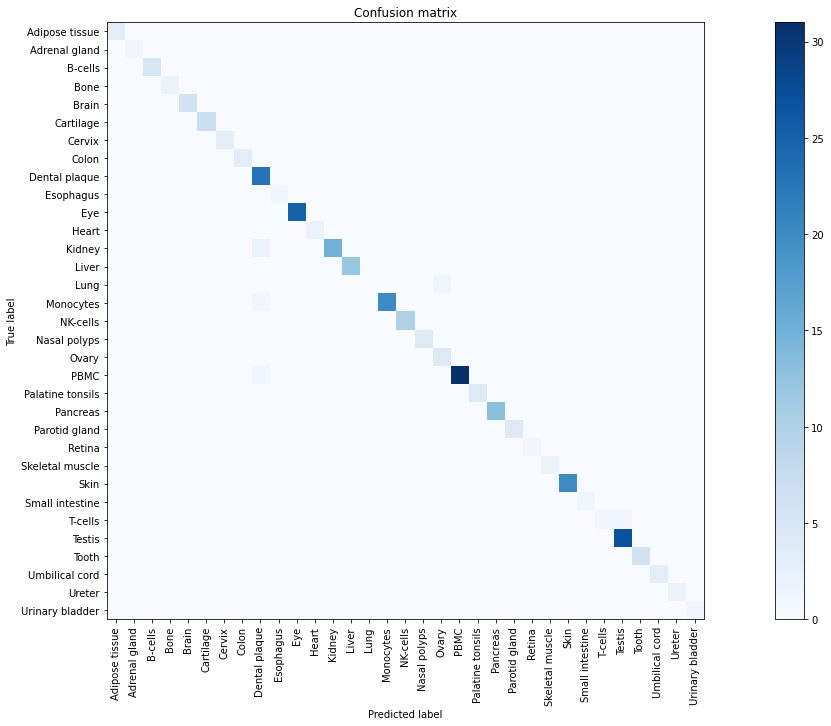

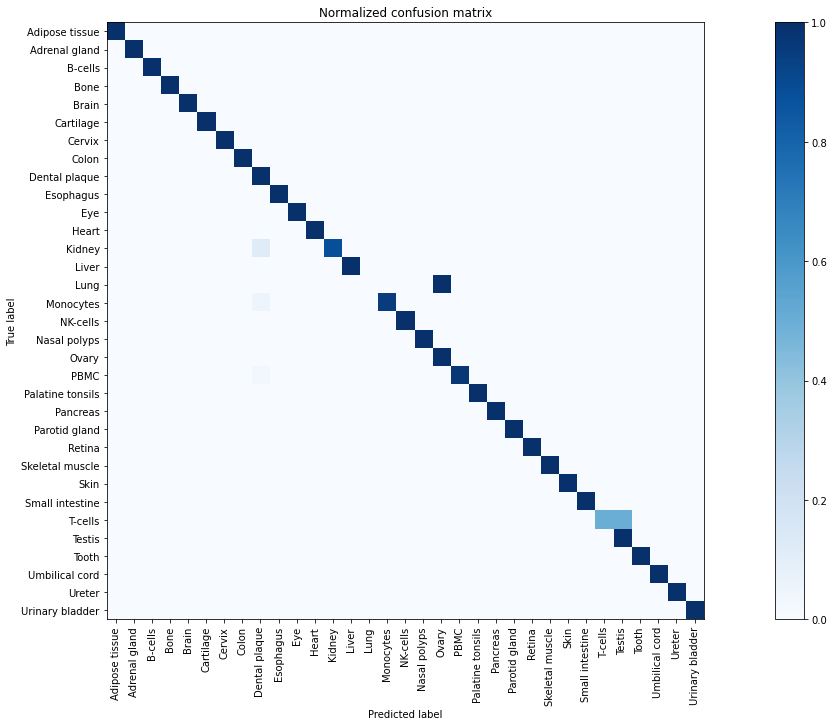

In [36]:
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_test, baseline_predictions)
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)
plt.figure(figsize=(20,10))
plot_confusion_matrix(cm, y_test)

# Normalize the confusion matrix by row (i.e by the number of samples
# in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure(figsize=(20,10))
plot_confusion_matrix(cm_normalized, y_test, title='Normalized confusion matrix')
cm_normalized.savefig('confusion_matrix_normalized_RF_90_nofluid_2010.png')

In [105]:
filename = '/home/compomics/git/Tissue_specific/Shotgun_no_fluid_atlas/Summary/tissue_predictor_RF_2010.pkl'
pickle.dump(forest, open(filename, 'wb'))

In [3]:
filename = '/home/compomics/git/Tissue_specific/Shotgun_no_fluid_atlas/Summary/tissue_predictor_RF_2010.pkl'
forest = pickle.load(open(filename, 'rb'))

In [6]:
X = atlas.iloc[:, :-1]
protein_names = X.columns
y = atlas['tissue_name']

In [22]:
with open('used_features.txt', 'w') as f:
    f.write(str(list(X.columns)))

# Biological Analysis using feature analysis

In [137]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],axis=0) #compute standard deviation of the feature importance over all the DecisionTreeClassifiers in the Random Forest
feature_names = X.columns

In [138]:
rf_features_df = pd.DataFrame(columns=['feature_name', 'importance', 'standard deviation'])

In [139]:
for f in range(X.shape[1]-1):
    rf_features_df.loc[f] = [feature_names[f], importances[f], std[f]]

In [ ]:
pd.set_option('display.float_format', lambda x: '%.8f' % x)

rf_features_df.sort_values(['importance'], axis=0, ascending=False)

In [44]:
rf_features_df.to_csv('/home/compomics/git/Tissue_specific/Shotgun_no_fluid_atlas/Summary/RF_2010_tissue_all_features.csv', index=False)

In [45]:
protein_names = X.columns[:-1]
with open('/home/compomics/git/Tissue_specific/Shotgun_no_fluid_atlas/Summary/RF_2010_tissue_all_features.txt', 'w') as f:
    for item in protein_names:
        f.write("%s\n" % item)

In [46]:
classes = forest.classes_

# Using the OneVsRestClassifier

Opnieuw X_train en y_train maken!

/home/compomics/anaconda/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:951: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/compomics/anaconda/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:951: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


<Figure size 432x288 with 0 Axes>

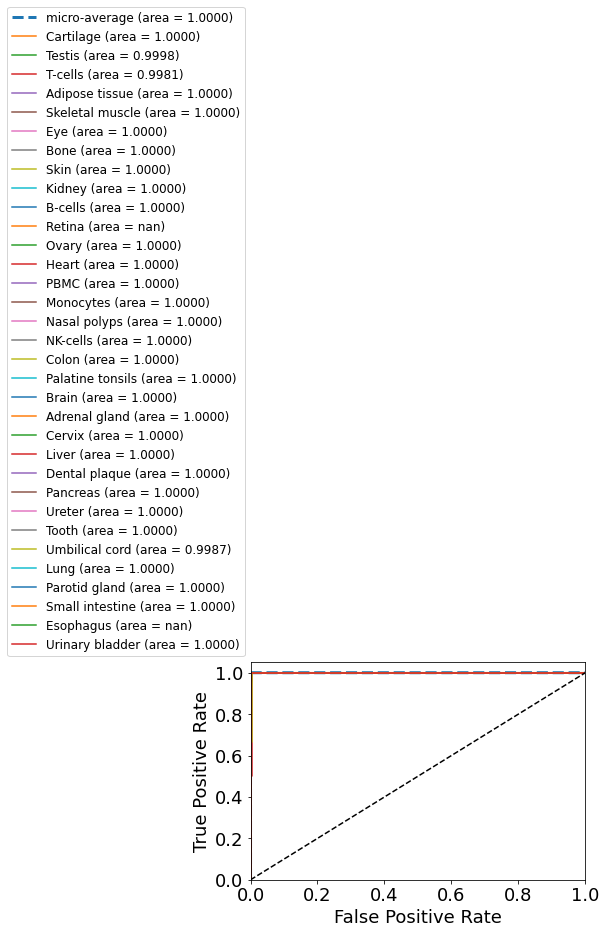

In [63]:
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import roc_curve, auc

rf_vs = OneVsRestClassifier(forest)
classes =list(set(y))
y_bin = label_binarize(y, classes=classes)
X_train_vs, X_test_vs, y_train_vs, y_test_vs= train_test_split(X, y_bin, test_size=.20, random_state=0, stratify=y)
y_score_vs = rf_vs.fit(X_train_vs, y_train_vs).predict_proba(X_test_vs)


fpr, tpr, roc_auc = {}, {}, {}
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_vs[:,i], y_score_vs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_vs.ravel(), y_score_vs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curve
sns.reset_orig()
plt.clf()
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],'--', linewidth=3, label='micro-average (area = {0:0.4f})'
            ''.format(roc_auc["micro"]))
for i in range(num_classes):
    pos = classes[i]
    plt.plot(fpr[i], tpr[i], label='{0} (area = {1:0.4f})'
                ''.format(pos, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.legend(bbox_to_anchor=(0,1), loc="lower right",fontsize=12)
#plt.gcf()



In [131]:
from sklearn.metrics import classification_report
ovr =  OneVsRestClassifier(forest).fit(X_train, y_train)
prediction = ovr.predict(X_test)
cr = classification_report(y_test, prediction)
# Evaluating the model
print(f"Test Set Accuracy : {accuracy_score(y_test, prediction) * 100} %\n\n")
print(f"Classification Report : \n\n{classification_report(y_test, prediction)}")

Test Set Accuracy : 96.64179104477611 %


Classification Report : 

                  precision    recall  f1-score   support

  Adipose tissue       0.75      1.00      0.86         3
   Adrenal gland       0.00      0.00      0.00         1
         B-cells       1.00      1.00      1.00         5
            Bone       1.00      1.00      1.00         2
           Brain       0.86      1.00      0.92         6
       Cartilage       1.00      1.00      1.00         7
          Cervix       1.00      1.00      1.00         3
           Colon       1.00      1.00      1.00         3
   Dental plaque       0.88      1.00      0.94        23
       Esophagus       1.00      1.00      1.00         1
             Eye       1.00      1.00      1.00        25
           Heart       1.00      1.00      1.00         2
          Kidney       1.00      0.88      0.94        17
           Liver       1.00      0.83      0.91        12
            Lung       1.00      1.00      1.00         1
   

In [132]:
with open("classification_report_ovr.txt", "w") as text_file:
    text_file.write(cr)

In [140]:
for i in range(len(ovr.estimators_)):     
    pred_class = classes[i]
    print(pred_class)
    pred = rf_vs.estimators_[i]
    importances = pred.feature_importances_
    std = np.std([tree.feature_importances_ for tree in pred.estimators_],axis=0) #compute standard deviation of the feature importance over all the DecisionTreeClassifiers in the Random Forest
    
    rf_features_df = pd.DataFrame(columns=['feature_name', 'importance', 'standard deviation'])
    for f in range(X.shape[1]):
        rf_features_df.loc[f] = [feature_names[f], importances[f], std[f]]
    values = (rf_features_df['importance'] != 0).sum()
    rf_features_df.to_csv('/home/compomics/git/Tissue_specific/Shotgun_no_fluid_atlas/Summary/Feature_imp_class_filtered_tissue/{}.csv'.format(pred_class))
    print('{} contains {} not-zero features'.format(pred_class, values))


Cartilage
Cartilage contains 624 not-zero features
Testis
Testis contains 1048 not-zero features
T-cells
T-cells contains 649 not-zero features
Adipose tissue
Adipose tissue contains 635 not-zero features
Skeletal muscle
Skeletal muscle contains 194 not-zero features
Eye
Eye contains 692 not-zero features
Bone
Bone contains 272 not-zero features
Skin
Skin contains 967 not-zero features
Kidney
Kidney contains 935 not-zero features
B-cells
B-cells contains 380 not-zero features
Retina
Retina contains 118 not-zero features
Ovary
Ovary contains 405 not-zero features
Heart
Heart contains 426 not-zero features
PBMC
PBMC contains 1002 not-zero features
Monocytes
Monocytes contains 743 not-zero features
Nasal polyps
Nasal polyps contains 204 not-zero features
NK-cells
NK-cells contains 282 not-zero features
Colon
Colon contains 356 not-zero features
Palatine tonsils
Palatine tonsils contains 246 not-zero features
Brain
Brain contains 685 not-zero features
Adrenal gland
Adrenal gland contains 1

# Application on fluid data

In [23]:
fluid_atlas = pd.read_csv('/home/compomics/git/Tissue_specific/Shotgun_no_fluid_atlas/tissue_predictor_all_diseases_atlas_shotgun_only_fluid.csv', sep=',')
fluid_atlas.head()

,assay_id,A0A024RBG1,A0A075B6H7,A0A075B6H8,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I7,A0A075B6I9,A0A075B6J1,...,Q9Y6Y0,Q9Y6Y1,Q9Y6Y8,Q9Y6Y9,Q9Y6Z5,Q9Y6Z7,cell_type,tissue_name,disease_status,fluid
0,27719,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000947,0.0,0.0,0.003421,Blood platelets,Blood,Healthy,1
1,27720,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,Blood platelets,Blood,Healthy,1
2,27721,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,Blood platelets,Blood,Healthy,1
3,27722,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000785,0.0,0.0,0.000000,Blood platelets,Blood,Healthy,1
4,27724,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,Blood platelets,Blood,Healthy,1


In [24]:
fluid_atlas = fluid_atlas.replace(to_replace =["Cell culture + cancer"], value ="Cell culture")
fluid_atlas = fluid_atlas.replace(to_replace =["Cancer (tissue far from Cancer)"], value ="Cancer")
fluid_atlas = fluid_atlas.replace(to_replace =["Cancer (tissue near to Cancer)"], value ="Cancer")
fluid_atlas = fluid_atlas.replace(to_replace =["cancer"], value ="Cancer")
fluid_atlas = fluid_atlas.replace(to_replace =["diseased"], value ="Diseased")

**This atlas contains fluid which are not present in the original predictor, how will these will be classified?**

In [25]:
#if protein is not found in the fluid atlas but is necessary for the predictor, add it as zero values (same was done in the predictor for not found proteins)
#also drop columns containing proteins that are not in the predictor
protein_names = atlas.columns[:-1].tolist()
fluid_prot = fluid_atlas.columns[:-4].tolist()
not_found_prot = list(set(protein_names) - set(fluid_prot))
common = set(protein_names).intersection(fluid_prot)

In [26]:
y = fluid_atlas[['tissue_name']]
disease_status = fluid_atlas[['disease_status']]
#project_id = fluid_atlas[['project_id']]
#PXD_accession = fluid_atlas[['PXD_accession']]
cell_type = fluid_atlas[['cell_type']]
assay_id = fluid_atlas[['assay_id']]
X = fluid_atlas[common]
for prot in not_found_prot:
    X[prot] = 0

/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [27]:
def sample_predict_class(test_sample, model, number_of_preds):
    values = (model.predict_proba(test_sample)).tolist()
    values = [item for sublist in values for item in sublist]
    classes = (model.classes_).tolist()
    d = dict(zip(classes, values))
    d = {k: v for k, v in sorted(d.items(), key=lambda item: item[1], reverse=True)}
    d_pairs = list((d.items()))
    return d_pairs[:number_of_preds]

In [28]:
disease_status2 = list(np.unique(disease_status))

In [29]:
disease_status2

['Cancer',
 'Cell culture',
 'Diseased',
 'Extracellular vesicles of the tissue were isolated',
 'Healthy',
 'No distinct annotation',
 'Unknown']

In [31]:
import random
fluid_predictions = pd.DataFrame(columns=['True tissue', 'Pred1', 'Pred2', 'Pred3', 'Pred4', 'Pred5', 'Pred6', 'Pred7'])
fluid_index = list(np.where(disease_status=='Healthy')[0])
for _ in range(35):
    for i in random.sample(fluid_index,1):
        test_sample = X.iloc[i:i+1]
        test_tissue = y.iloc[i].to_string(header=False, index=False)
        predictions = sample_predict_class(test_sample, forest, 7)
        pred1, pred2, pred3, pred4, pred5, pred6, pred7 = predictions
        df_length = len(fluid_predictions)
        fluid_predictions.loc[df_length] = [test_tissue, pred1, pred2, pred3, pred4, pred5, pred6, pred7]
fluid_predictions

,True tissue,Pred1,Pred2,Pred3,Pred4,Pred5,Pred6,Pred7
0,Peritoneal dialysis fluid,"(Dental plaque, 0.42)","(Cartilage, 0.36)","(Tooth, 0.11)","(Adipose tissue, 0.03)","(Adrenal gland, 0.02)","(Bone, 0.01)","(Brain, 0.01)"
1,Peritoneal dialysis fluid,"(Dental plaque, 0.42)","(Cartilage, 0.37)","(Tooth, 0.12)","(B-cells, 0.02)","(Testis, 0.02)","(Adipose tissue, 0.01)","(Adrenal gland, 0.01)"
2,Blood,"(Dental plaque, 0.46)","(Cartilage, 0.34)","(Tooth, 0.1)","(Adrenal gland, 0.02)","(Parotid gland, 0.02)","(Testis, 0.02)","(Umbilical cord, 0.02)"
3,Blood,"(Retina, 0.2)","(Adrenal gland, 0.14)","(Parotid gland, 0.12)","(Skeletal muscle, 0.1)","(Small intestine, 0.07)","(NK-cells, 0.06)","(Palatine tonsils, 0.06)"
4,Blood,"(Dental plaque, 0.42)","(Cartilage, 0.37)","(Tooth, 0.1)","(Heart, 0.06)","(Testis, 0.02)","(Brain, 0.01)","(Esophagus, 0.01)"
5,Blood,"(Dental plaque, 0.39)","(Cartilage, 0.37)","(Tooth, 0.12)","(Nasal polyps, 0.03)","(Testis, 0.03)","(Pancreas, 0.02)","(Brain, 0.01)"
6,Blood,"(Dental plaque, 0.44)","(Cartilage, 0.39)","(Tooth, 0.13)","(B-cells, 0.01)","(Brain, 0.01)","(Skin, 0.01)","(Testis, 0.01)"
7,Blood,"(Dental plaque, 0.38)","(Cartilage, 0.32)","(Tooth, 0.1)","(Adrenal gland, 0.03)","(B-cells, 0.03)","(Palatine tonsils, 0.03)","(Testis, 0.03)"
8,Blood,"(Dental plaque, 0.23)","(Cartilage, 0.16)","(Cervix, 0.12)","(Testis, 0.07)","(Heart, 0.06)","(Nasal polyps, 0.05)","(Tooth, 0.05)"
9,Blood,"(Dental plaque, 0.25)","(Cartilage, 0.19)","(Heart, 0.09)","(Cervix, 0.06)","(Testis, 0.05)","(Tooth, 0.05)","(NK-cells, 0.04)"


# Application on diseased data

In [179]:
diseased_atlas = pd.read_csv('/home/compomics/git/Tissue_specific/Shotgun_no_fluid_atlas/filtered_90_tissue_predictor_all_diseases_atlas_shotgun_nofluid.csv', sep=",")
diseased_atlas = diseased_atlas[(diseased_atlas['disease_status'] != 'Healthy') & (diseased_atlas['tissue_name'] != 'Unknown')]
diseased_atlas = diseased_atlas[~diseased_atlas['disease_status'].isin(['Healthy', 'Unknown', 'Extracellular vesicles of the tissue were isolated', 'No distinct annotation', 'no distinct annotation'])]

In [180]:
diseased_atlas.columns

Index(['A0A075B6H7', 'A0A075B6H8', 'A0A075B6H9', 'A0A075B6I0', 'A0A075B6I1',
       'A0A075B6K4', 'A0A075B6Q5', 'A0A087WSY6', 'A0A0A0MRZ7', 'A0A0A0MS14',
       ...
       'Q9Y6W3', 'Q9Y6W5', 'Q9Y6X5', 'Q9Y6X8', 'Q9Y6X9', 'Q9Y6Y0', 'Q9Y6Y8',
       'cell_type', 'tissue_name', 'disease_status'],
      dtype='object', length=4984)

In [181]:
diseased_atlas = diseased_atlas.replace(to_replace =["Cell culture + cancer"], value ="Cell culture")
diseased_atlas = diseased_atlas.replace(to_replace =["Cancer (tissue far from Cancer)"], value ="Cancer")
diseased_atlas = diseased_atlas.replace(to_replace =["Cancer (tissue near to Cancer)"], value ="Cancer")
diseased_atlas = diseased_atlas.replace(to_replace =["cancer"], value ="Cancer")
diseased_atlas = diseased_atlas.replace(to_replace =["diseased"], value ="Diseased")

In [182]:
np.unique(diseased_atlas['disease_status'])

array(['Cancer', 'Cell culture', 'Diseased', 'Organoid'], dtype=object)

**In a new atlas, only the proteins which are also present in the model can be used**

In [183]:
trained_tissues = np.unique(atlas['tissue_name'])
protein_names = atlas.columns[:-1].tolist()

In [184]:
diseased_atlas_c.columns

NameError: name 'diseased_atlas_c' is not defined

In [ ]:
diseased_prot = diseased_atlas_c.columns[:-3].tolist()

In [ ]:
y = diseased_atlas_c[['tissue_name']]
disease_status = diseased_atlas_c[['disease_status']]
#project_id = diseased_atlas_c[['project_id']]
#PXD_accession = diseased_atlas_c[['PXD_accession']]
cell_type = diseased_atlas_c[['cell_type']]
#assay_id = diseased_atlas_c[['assay_id']]
X = diseased_atlas_c[protein_names]

In [ ]:
def sample_predict_class(test_sample, model):
    values = (model.predict_proba(test_sample)).tolist()
    values = [item for sublist in values for item in sublist]
    classes = (model.classes_).tolist()
    d = dict(zip(classes, values))
    d = {k: v for k, v in sorted(d.items(), key=lambda item: item[1], reverse=True)}
    d_pairs = list((d.items()))
    return d_pairs[:5]

In [ ]:
disease_status2 = list(np.unique(disease_status))

empty
Diseased
f1 score = 0.7199439337294129
accuracy score = 0.6859688195991092
precision score = 0.7616926503340757
recall score = 0.6859688195991092
Diseased Normalized confusion matrix
[[0.9  0.1  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.  ]
 [ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
   nan  nan  nan]
 [ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
   nan  nan  nan]
 [ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
   nan  nan  nan]
 [ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
   nan  nan  nan]
 [0.   0.2  0.   0.   0.   0.69 0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.08 0.02]
 [ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
   nan  nan  nan]
 [0.   0.   0.   0.   0.   0.   0.05 0.95 0.   0.   0.   0.   0.   0.
  0.   0.   0.  ]
 [0.   0.21 0.   0.01 0.76 0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.01 0.  ]
 [ nan  n

/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide


empty
Organoid
f1 score = 0.0
accuracy score = 0.0
precision score = 0.0
recall score = 0.0
Organoid Normalized confusion matrix
[[nan nan nan]
 [nan nan nan]
 [0.5 0.5 0. ]]


/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide


Cell culture
f1 score = 0.557472815366075
accuracy score = 0.491588785046729
precision score = 0.7685800422068134
recall score = 0.491588785046729
Cell culture Normalized confusion matrix
[[0.6  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.4  0.   0.  ]
 [ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
   nan  nan  nan  nan  nan]
 [0.   0.   0.8  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.2  0.
  0.   0.   0.   0.   0.  ]
 [ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
   nan  nan  nan  nan  nan]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.7  0.
  0.3  0.   0.   0.   0.  ]
 [0.   0.42 0.   0.38 0.   0.08 0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.12 0.  ]
 [ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
   nan  nan  nan  nan  nan]
 [0.   0.04 0.   0.   0.   0.   0.69 0.2  0.   0.   0.   0.   0.01 0.
  0.   0.   0.05 0.   0.  ]
 [0.   0.21 0.   0.01 

/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide


Cancer
f1 score = 0.4503777956380103
accuracy score = 0.3933333333333333
precision score = 0.7427668512144122
recall score = 0.3933333333333333
Cancer Normalized confusion matrix
[[ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
   nan  nan  nan  nan  nan  nan  nan]
 [0.   0.   0.   0.   0.   0.4  0.38 0.06 0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.03 0.12 0.01 0.  ]
 [ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
   nan  nan  nan  nan  nan  nan  nan]
 [0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.74 0.02 0.   0.14 0.   0.   0.   0.   0.   0.1
  0.   0.   0.   0.   0.   0.   0.  ]
 [ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
   nan  nan  nan  nan  nan  nan  nan]
 [ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
   nan  nan  nan  nan  nan  nan  nan]
 [0.   0.   0.15 0.   0.   0.   0.   0.78 0.   0.   0.  

/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/compomics/miniconda3/envs/tissuespecific/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide


empty


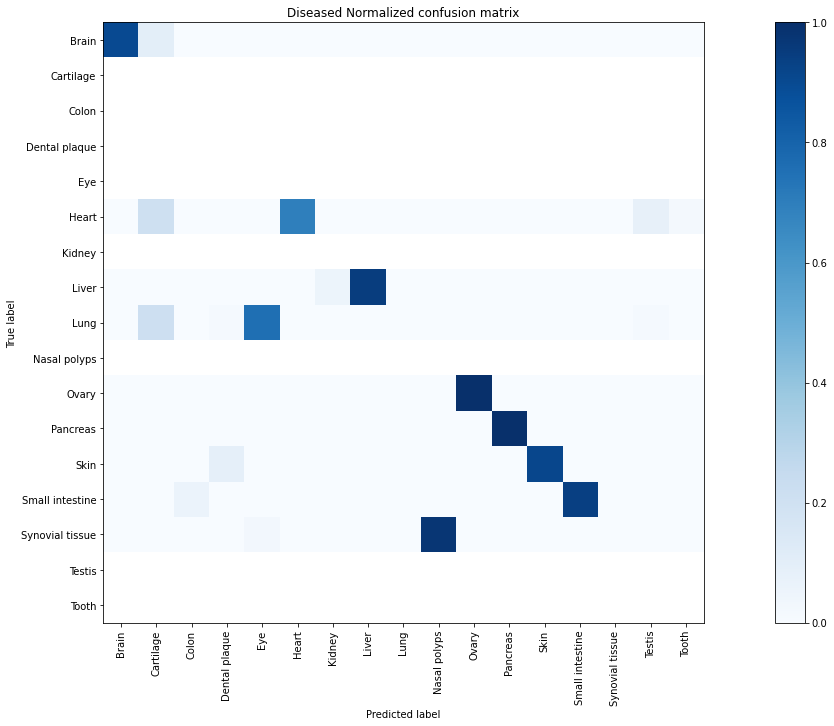

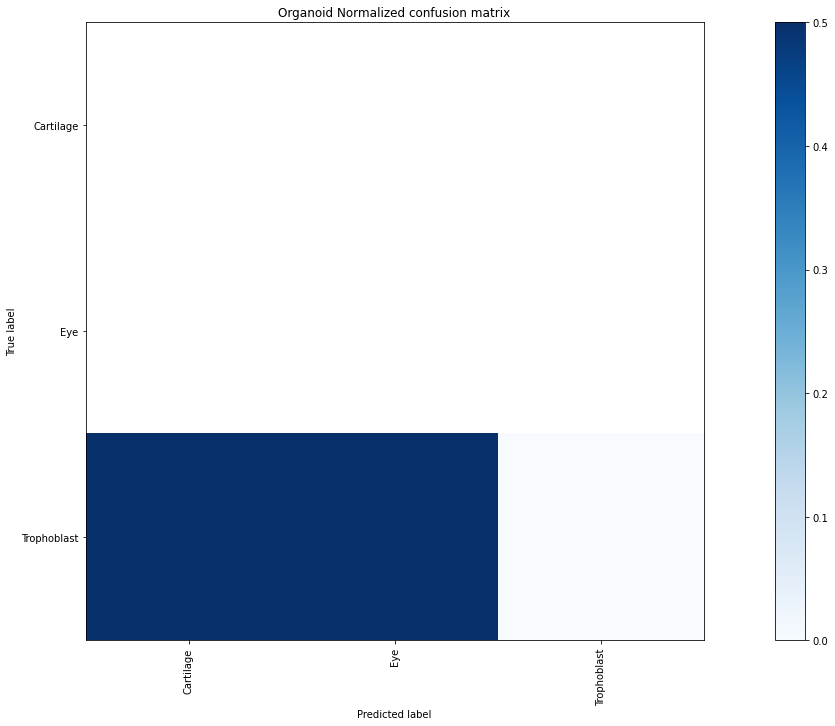

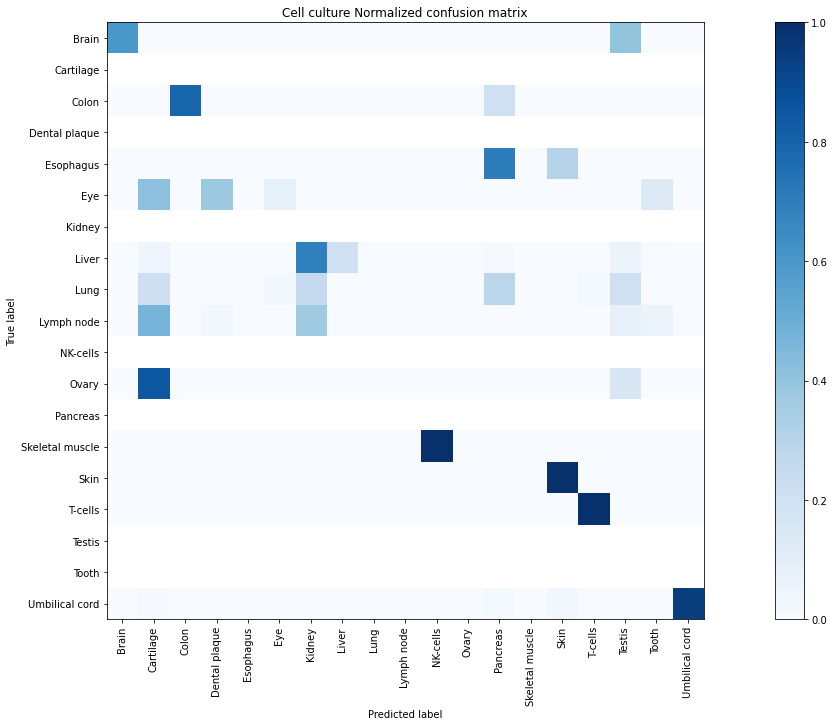

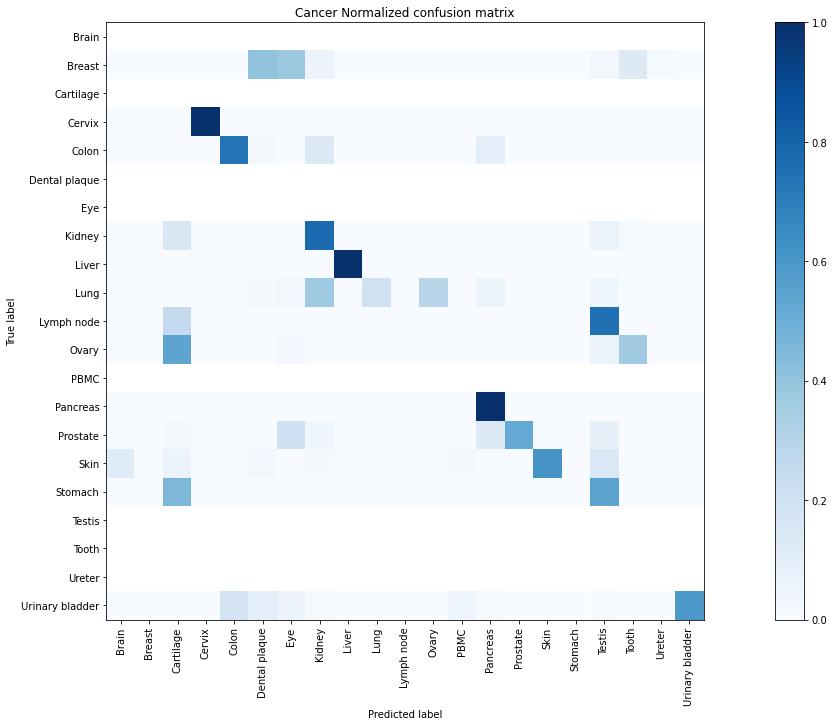

In [ ]:
ind = 0
for i in set(disease_status2):
    ind += 1
    cancerous_atlas_c = diseased_atlas.copy(deep=True)
    cancerous_atlas_c = cancerous_atlas_c[cancerous_atlas_c['disease_status'] == i]

    y_cancerous = cancerous_atlas_c[['tissue_name']]
    cancerous_disease_status = cancerous_atlas_c[['disease_status']]
    #cancerous_project_id = cancerous_atlas_c[['project_id']]
    #cancerous_PXD_accession = cancerous_atlas_c[['PXD_accession']]
    cancerous_cell_type = cancerous_atlas_c[['cell_type']]
    #cancerous_assay_id = cancerous_atlas_c[['assay_id']]
    X_cancerous = cancerous_atlas_c[protein_names]
    if X_cancerous.shape[0] == 0:
        print('empty')
        continue
    predictions_cancerous = forest_opt.predict(X_cancerous)
    print(i)
    print('f1 score = {}'.format(f1_score(y_cancerous, predictions_cancerous, average='weighted'))) #use weighted, which takes into account class imbalance (the weighted dict is used int he fitting of the algorithm and adapted to the training data but this diseased data is imbalanced and this is not taken into account int he algorithm)
    print('accuracy score = {}'.format(accuracy_score(y_cancerous, predictions_cancerous)))
    print('precision score = {}'.format(precision_score(y_cancerous, predictions_cancerous, average='weighted')))
    print('recall score = {}'.format(recall_score(y_cancerous, predictions_cancerous, average='weighted')))
    from sklearn.metrics import confusion_matrix
    #merge predictions
    labels = list(set(y_cancerous['tissue_name'].tolist()).union(set(predictions_cancerous)))
    # Compute confusion matrix
    cm = confusion_matrix(y_cancerous, predictions_cancerous)
    np.set_printoptions(precision=2)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print('{} Normalized confusion matrix'.format(i))
    print(cm_normalized)
    plt.figure(figsize=(20,10))
    plt.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('{} Normalized confusion matrix'.format(i))
    plt.colorbar()
    tick_marks = np.arange(len(np.unique(labels)))
    plt.xticks(tick_marks, np.unique(labels), rotation=90)
    plt.yticks(tick_marks, np.unique(labels))
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
set(y_cancerous['tissue_name'].to_list()) - set(predictions_cancerous)

set()

In [ ]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(np.unique(y_test)))
    plt.xticks(tick_marks, np.unique(y_test), rotation=90)
    plt.yticks(tick_marks, np.unique(y_test))
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
import random
diseased_predictions = pd.DataFrame(columns=['True tissue', 'Pred1', 'Pred2', 'Pred3', 'Pred4', 'Pred5'])
diseased_index = list(np.where(disease_status=='Diseased')[0])
for _ in range(15):
    for i in random.sample(diseased_index,1):
        test_sample = X.iloc[i:i+1]
        test_tissue = y.iloc[i].to_string(header=False, index=False)
        predictions = sample_predict_class(test_sample, forest_opt)
        pred1, pred2, pred3, pred4, pred5 = predictions
        df_length = len(diseased_predictions)
        diseased_predictions.loc[df_length] = [test_tissue, pred1, pred2, pred3, pred4, pred5]
diseased_predictions

,True tissue,Pred1,Pred2,Pred3,Pred4,Pred5
0,Pancreas,"(Pancreas, 0.5488493961604074)","(Kidney, 0.08612932835656287)","(Testis, 0.059749454127828505)","(Ovary, 0.03654539022021645)","(Skin, 0.0287812945540371)"
1,Ovary,"(Ovary, 0.7182381350821859)","(Lung, 0.050460341936304616)","(Testis, 0.04625130392597204)","(Kidney, 0.021639994447757827)","(Bone, 0.017730716624366066)"
2,Small intestine,"(Small intestine, 0.24642265698503762)","(Colon, 0.1786437537964738)","(B-cells, 0.05875291048038215)","(Parotid gland, 0.05806031148480817)","(Palatine tonsils, 0.050668524561820354)"
3,Skin,"(Skin, 0.18444587614428923)","(Dental plaque, 0.18386909969884535)","(Eye, 0.11473297053059373)","(Adipose tissue, 0.0853444319380317)","(Kidney, 0.0788499231412243)"
4,Skin,"(Skin, 0.3722143823151038)","(PBMC, 0.08909545432209938)","(Adipose tissue, 0.06616476923012445)","(Umbilical cord, 0.059825890274319275)","(Esophagus, 0.05136471273428264)"
5,Synovial tissue,"(Nasal polyps, 0.15807918736279586)","(Eye, 0.11249812855148553)","(Bone, 0.10063874890820985)","(Skin, 0.06285797314198353)","(Ureter, 0.05317670480342238)"
6,Liver,"(Liver, 0.6243126570611424)","(Kidney, 0.09106120748145322)","(Testis, 0.05378718624356037)","(Pancreas, 0.03515581354394719)","(Skin, 0.02169949740756082)"
7,Skin,"(Skin, 0.29459612449723405)","(PBMC, 0.10643935052606043)","(Umbilical cord, 0.08094810636933861)","(Adipose tissue, 0.07559182598900341)","(Esophagus, 0.07201940490979819)"
8,Pancreas,"(Pancreas, 0.36124252080649866)","(Cartilage, 0.09362255432788516)","(Tooth, 0.08813828844875513)","(Brain, 0.06124795007927024)","(Eye, 0.0541578665579435)"
9,Synovial tissue,"(Nasal polyps, 0.16088079871291794)","(Eye, 0.12498860001404667)","(Bone, 0.10612651043119783)","(Skin, 0.0727959706447669)","(Ureter, 0.06091407745886424)"


# Feature reduction

In [70]:
features_RF_baseline = sorted(forest.feature_importances_, reverse=True)
with open('features_imp_RF_baseline_2010.txt', 'w') as f:
    for item in features_RF_baseline:
        f.write("%s\n" % item)

In this list, only 2354 proteins have a feature importance above 0 and 240 above 0.001

Lets fit a model on the first 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 2000, 3000, 4000 4981 (all) ==> 15 models and see how the metrics changes

In [71]:
features_RF_baseline = sorted(forest.feature_importances_, reverse=True)

In [81]:
thresholds = [50, 100, 200, 300, 400, 500, 600, 610, 611,612,613,614,615,616,617,618,619, 620, 630, 640, 650, 660, 670, 680, 690, 700, 800, 900, 1000, 2000, 3000, 4000, 4981]
thresholds_cut = []
for i in range(580, 631):
    thresholds_cut.append(features_RF_baseline[i-1])

In [82]:
import warnings
warnings.filterwarnings("ignore")

In [83]:
accs = []
fms = []
pms = []
rms = []
for t in thresholds_cut:
    selection = SelectFromModel(forest, threshold=t, prefit=True)
    select_X_train = selection.transform(X_train)
    selection_model = RandomForestClassifier(random_state=0, class_weight='balanced_subsample', n_jobs=-1)
    selection_model.fit(select_X_train, y_train)
    select_X_test = selection.transform(X_test)
    predictions = selection_model.predict(select_X_test)
    fm = f1_score(y_test, predictions, average="macro")
    acc = accuracy_score(y_test, predictions)
    pm = precision_score(y_test, predictions, average='macro')
    rm = recall_score(y_test, predictions, average='macro')
    accs.append(acc)
    fms.append(fm)
    pms.append(pm)
    rms.append(rm)
    print("t=%.6f , n=%d, Accuracy=%.4f%%, F1-score = %.4f%%, Precision = %.4f%%, Recall =%.4f%% " % (t, select_X_train.shape[1], acc*100.0, fm*100.0, pm*100.0, rm*100.0 ))

t=0.000569 , n=580, Accuracy=98.1343%, F1-score = 96.0792%, Precision = 95.9147%, Recall =96.3742% 
t=0.000567 , n=581, Accuracy=98.1343%, F1-score = 96.0792%, Precision = 95.9147%, Recall =96.3742% 
t=0.000564 , n=582, Accuracy=98.5075%, F1-score = 99.4462%, Precision = 99.5511%, Recall =99.4045% 
t=0.000564 , n=583, Accuracy=98.1343%, F1-score = 96.3608%, Precision = 96.4125%, Recall =96.3742% 
t=0.000564 , n=584, Accuracy=98.1343%, F1-score = 96.0792%, Precision = 95.9147%, Recall =96.3742% 
t=0.000564 , n=585, Accuracy=98.1343%, F1-score = 96.3608%, Precision = 96.4125%, Recall =96.3742% 
t=0.000563 , n=586, Accuracy=98.5075%, F1-score = 99.4462%, Precision = 99.5511%, Recall =99.4045% 
t=0.000562 , n=587, Accuracy=98.1343%, F1-score = 96.0792%, Precision = 95.9147%, Recall =96.3742% 
t=0.000562 , n=588, Accuracy=98.1343%, F1-score = 96.0792%, Precision = 95.9147%, Recall =96.3742% 
t=0.000560 , n=589, Accuracy=98.1343%, F1-score = 96.3298%, Precision = 96.3314%, Recall =96.3742% 


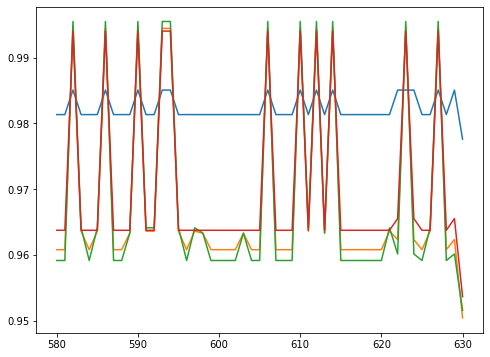

In [84]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
t = list(range(580, 631))
figure(figsize=(8,6))
plt.plot(t,accs)
plt.plot(t,fms)
plt.plot(t,pms)
plt.plot(t,rms)
plt.show()

The most optimal accuracy and f1 score are achieved when using 750 features. This is in contrast to the PCA analysis which found that 250 features contributed to 97.5% of the variance.

In [85]:
selection = SelectFromModel(forest, threshold=0.000564, prefit=True)
X_train_treshold = selection.transform(X_train)
forest_treshold = RandomForestClassifier(class_weight='balanced_subsample', n_jobs=-1, random_state=42)
forest_treshold.fit(X_train_treshold, y_train)
X_test_treshold = selection.transform(X_test)
predictions_forest_treshold = forest_treshold.predict(X_test_treshold)
accuracy = accuracy_score(y_test, predictions_forest_treshold)
f1 = f1_score(y_test, predictions_forest_treshold, average="weighted")
pm = precision_score(y_test, predictions_forest_treshold, average='macro')
rm = recall_score(y_test, predictions_forest_treshold, average='macro')
print(f1)
print(accuracy)
print(pm)
print(rm)

0.9799735967375666
0.9813432835820896
0.9591470258136925
0.9637419361684068


## Analyse the features that were selected 

In [141]:
feature_idx = selection.get_support()
feature_names = X_train.columns[feature_idx]

In [142]:
print(feature_names)

Index(['A0A075B6I0', 'A0A0A0MRZ7', 'A0A0A0MS14', 'A0A0A0MS15', 'A0A0B4J1V0',
       'A0A0C4DH25', 'A0A0C4DH29', 'A0A0C4DH31', 'A0A0G2JMI3', 'A8K2U0',
       ...
       'Q9Y394', 'Q9Y3D2', 'Q9Y3D6', 'Q9Y3I1', 'Q9Y490', 'Q9Y5L3', 'Q9Y623',
       'Q9Y6C2', 'Q9Y6N9', 'Q9Y6R1'],
      dtype='object', length=583)


In [143]:
set(feature_names) - set(X.columns)

set()

In [144]:
X_threshold = X[feature_names]
X_test_threshold = X_test[feature_names]
y_threshold = y

In [145]:
result_df = pd.DataFrame(columns=['model', 'Accuracy', 'f1_macro', 'precision_macro', 'recall_macro', 'f1_weighted', 'precision_weighted', 'recall_weighted'])

In [146]:
rf_vs = OneVsRestClassifier(forest_treshold).fit(X_train_treshold,y_train)


<Figure size 432x288 with 0 Axes>

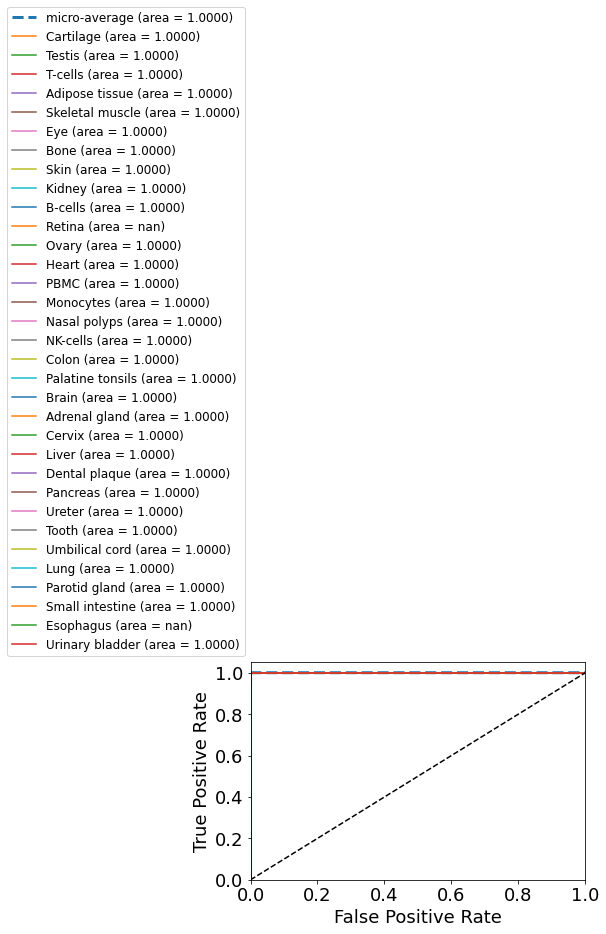

In [97]:
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import roc_curve, auc

rf_vs_threshold = OneVsRestClassifier(forest_treshold)
classes =list(set(y_threshold))
y_bin = label_binarize(y, classes=classes)
X_train_vs_threshold, X_test_vs_threshold, y_train_vs_threshold, y_test_vs_threshold= train_test_split(X_threshold, y_bin, test_size=.20, random_state=0, stratify=y)
y_score_vs_threshold = rf_vs_threshold.fit(X_train_vs_threshold, y_train_vs_threshold).predict_proba(X_test_vs_threshold)


fpr, tpr, roc_auc = {}, {}, {}
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_vs_threshold[:,i], y_score_vs_threshold[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_vs_threshold.ravel(), y_score_vs_threshold.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curve
sns.reset_orig()
plt.clf()
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],'--', linewidth=3, label='micro-average (area = {0:0.4f})'
            ''.format(roc_auc["micro"]))
for i in range(num_classes):
    pos = classes[i]
    plt.plot(fpr[i], tpr[i], label='{0} (area = {1:0.4f})'
                ''.format(pos, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.legend(bbox_to_anchor=(0,1), loc="lower right",fontsize=12)
#plt.gcf()



In [148]:
from sklearn.metrics import classification_report
ovr =  OneVsRestClassifier(forest_treshold).fit(X_train_treshold, y_train)
prediction = ovr.predict(X_test_treshold)
cr = classification_report(y_test, prediction)
# Evaluating the model
print(f"Test Set Accuracy : {accuracy_score(y_test, prediction) * 100} %\n\n")
print(f"Classification Report : \n\n{classification_report(y_test, prediction)}")

Test Set Accuracy : 98.50746268656717 %


Classification Report : 

                  precision    recall  f1-score   support

  Adipose tissue       1.00      1.00      1.00         3
   Adrenal gland       1.00      1.00      1.00         1
         B-cells       1.00      1.00      1.00         5
            Bone       1.00      1.00      1.00         2
           Brain       1.00      1.00      1.00         6
       Cartilage       1.00      1.00      1.00         7
          Cervix       1.00      1.00      1.00         3
           Colon       1.00      1.00      1.00         3
   Dental plaque       0.85      1.00      0.92        23
       Esophagus       1.00      1.00      1.00         1
             Eye       1.00      1.00      1.00        25
           Heart       1.00      1.00      1.00         2
          Kidney       1.00      0.88      0.94        17
           Liver       1.00      1.00      1.00        12
            Lung       1.00      1.00      1.00         1
   

In [103]:
with open("classification_report_ovr_treshold.txt", "w") as text_file:
    text_file.write(cr)

In [149]:
for i in range(len(ovr.estimators_)):     
    pred_class = classes[i]
    print(pred_class)
    pred = rf_vs.estimators_[i]
    importances = pred.feature_importances_
    std = np.std([tree.feature_importances_ for tree in pred.estimators_],axis=0) #compute standard deviation of the feature importance over all the DecisionTreeClassifiers in the Random Forest
    
    rf_features_df = pd.DataFrame(columns=['feature_name', 'importance', 'standard deviation'])
    for f in range(X.shape[1]):
        rf_features_df.loc[f] = [feature_names[f], importances[f], std[f]]
    values = (rf_features_df['importance'] != 0).sum()
    rf_features_df.to_csv('/home/compomics/git/Tissue_specific/Shotgun_no_fluid_atlas/Summary/Reduced_feature_imp_class_filtered_tissue/{}.csv'.format(pred_class))
    print('{} contains {} not-zero features'.format(pred_class, values))


Cartilage


IndexError: index 583 is out of bounds for axis 0 with size 583